# Config

First create a conda environment using the attached **environment.yml**.

Change these values according to your setup.

In [1]:
data_list_path = "../../../../JKU_misc/compvis/integrals/image_sets.json"
input_images_path = "../../../../JKU_misc/compvis/integrals/"
gt_path = "../../../../JKU_misc/compvis/batch_20230912_part1-007/Part1"

# Model definition

Here we define a u-net class. We only need to define the depth in the parameters during initialization and the layers will be created automatically with the right dimensions.

In [2]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p  # Return both output and pooled feature

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = conv_block(out_c * 2, out_c)  # Double the channels for concatenated skip connections

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)  # Concatenate with skip connection
        x = self.conv(x)
        return x

class unet(nn.Module):
    def __init__(self, depth, base_dim, in_channels, out_channels):
        super().__init__()
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()

        # Encoder layers
        self.encoders.append(encoder_block(in_channels, base_dim))
        print(f'Encoder created with dimensions ({in_channels}, {base_dim})')
        for _ in range(1, depth):
            self.encoders.append(encoder_block(base_dim, base_dim * 2))
            print(f'Encoder created with dimensions ({base_dim}, {base_dim * 2})')
            base_dim *= 2

        # Bottleneck
        self.bottleneck = conv_block(base_dim, base_dim * 2)
        print(f'Bottleneck created with dimensions ({base_dim}, {base_dim * 2})')
        

        # Decoder layers
        for _ in range(depth):
            self.decoders.append(decoder_block(base_dim * 2, base_dim))
            print(f'Decoder created with dimensions ({base_dim * 2}, {base_dim})')
            base_dim //= 2

        # Classifier
        # We multiply base_dim by two here because we did an unnecessary last divide in the previous for block
        self.outputs = nn.Conv2d(base_dim * 2, out_channels, kernel_size=1)
        print(f'Output created with dimensions ({base_dim}, {out_channels})')
        
        # Sigmoid to squeeze the output between 0-1
        self.sigmoid = nn.Sigmoid()


    def forward(self, inputs):
        skip_connections = []

        # Encoding path
        for encoder in self.encoders:
            inputs, pool = encoder(inputs)
            skip_connections.append(inputs)
            inputs = pool

        # Bottleneck
        x = self.bottleneck(inputs)

        # Decoding path
        skip_connections = skip_connections[::-1]  # Reverse for correct skip connections
        for i, decoder in enumerate(self.decoders):
            x = decoder(x, skip_connections[i])

        # Classifier
        outputs = self.outputs(x)
        outputs = self.sigmoid(outputs)
        return outputs

# Dataset definition

In [3]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class IntegralDataset(Dataset):
    def __init__(self, data_list, integrals_folder, gt_folder, transform=None):
        self.data_list = data_list
        self.integrals_folder = integrals_folder
        self.gt_folder = gt_folder
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        data_item = self.data_list[index]

        # Load integral images, convert to grayscale, and concatenate along the channel dimension
        integral_images = [Image.open(os.path.join(self.integrals_folder, integral['filename'])) for integral in data_item['integrals']]
        integral_images = [self.transform(image.convert('L')) for image in integral_images]  # Convert to grayscale
        integral_images = torch.cat(integral_images, dim=0)  # Concatenating along channel dimension

        # Load GT image
        gt_image = Image.open(os.path.join(self.gt_folder, data_item['GT']['filename']))
        gt_image = self.transform(gt_image)

        return integral_images, gt_image

### We also define the dataloader

In [4]:
import json
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor, Normalize, Compose, Grayscale

with open(data_list_path, 'r') as file:
    data_list = json.load(file)

# TEMPORARY: we only want a small subset of the data for now for faster running times
data_list = data_list[:100]
    
transform = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

# We split the data into 80% training and 20% validation
train_data, val_data = train_test_split(data_list, test_size=0.2)

# We create the datasets and the dataloaders
train_dataset = IntegralDataset(train_data, integrals_folder=input_images_path, gt_folder=gt_path, transform=transform)
val_dataset = IntegralDataset(val_data, integrals_folder=input_images_path, gt_folder=gt_path, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)


# Training the model

In [5]:
def train_model(model, train_dataloader, val_dataloader, loss_func, optimizer, num_epochs=25):
    print("Training started")
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)  # Stack of 3 images
            targets = targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate average training loss for the epoch
        train_loss /= len(train_dataloader)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = loss_func(outputs, targets)

                val_loss += loss.item()

        # Calculate average validation loss for the epoch
        val_loss /= len(val_dataloader)

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    print('Training complete')

### And then we run the testing

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import glob
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Torch is running on {device}')

# Initialize the U-Net and the parameters
model = unet(depth=4, base_dim=64, in_channels=3, out_channels=1).to(device)
loss = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_dataloader, val_dataloader, loss, optimizer, num_epochs=10)
torch.save(model, 'full_model.pth')

Torch is running on cuda:0
Encoder created with dimensions (3, 64)
Encoder created with dimensions (64, 128)
Encoder created with dimensions (128, 256)
Encoder created with dimensions (256, 512)
Bottleneck created with dimensions (512, 1024)
Decoder created with dimensions (1024, 512)
Decoder created with dimensions (512, 256)
Decoder created with dimensions (256, 128)
Decoder created with dimensions (128, 64)
Output created with dimensions (32, 1)
Training started
Epoch 1/10, Training Loss: 0.7486, Validation Loss: 0.5644
Epoch 2/10, Training Loss: 0.5725, Validation Loss: 0.6137
Epoch 3/10, Training Loss: 0.5199, Validation Loss: 0.4179
Epoch 4/10, Training Loss: 0.5042, Validation Loss: 0.3550
Epoch 5/10, Training Loss: 0.4776, Validation Loss: 0.3407
Epoch 6/10, Training Loss: 0.4666, Validation Loss: 0.3202
Epoch 7/10, Training Loss: 0.4565, Validation Loss: 0.3119
Epoch 8/10, Training Loss: 0.4406, Validation Loss: 0.3001
Epoch 9/10, Training Loss: 0.4521, Validation Loss: 0.3309

# Manually test the model

Here you can manually inspect the output of the model.

In [26]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import numpy as np

def display_model_output(model, data_list, index, transform, device):
    # Load and process the input images
    integral_image_paths = [os.path.join(input_images_path, integral['filename']) for integral in data_list[index]['integrals']]
    integral_images = [transform(Image.open(path).convert('L')) for path in integral_image_paths]
    input_tensor = torch.cat(integral_images, dim=0).unsqueeze(0).to(device)

    # Load the ground truth image
    gt_image_path = os.path.join(gt_path, data_list[index]['GT']['filename'])
    gt_image = Image.open(gt_image_path).convert('L')
    
    # Model inference
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # Convert model output to image
    output_image = to_pil_image(output.squeeze(0).cpu())
    
    # Display images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_tensor.squeeze(0).permute(1, 2, 0).cpu(), cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output_image, cmap='gray')
    plt.title('Model Output')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt_image, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


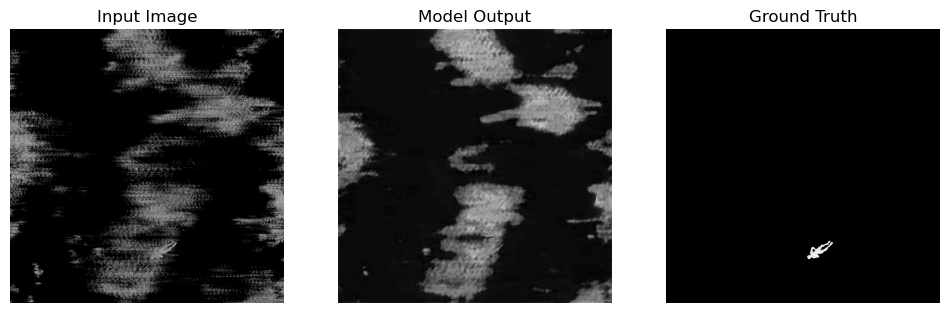

In [27]:
# Usage
index = 14 # Index of the image in data_list to test

display_model_output(model, data_list, index, transform, device)